## Reference mapping with scvi-tools

This tutorial covers the usage of the [scArches method](https://www.biorxiv.org/content/10.1101/2020.07.16.205997v1) with SCVI, SCANVI, and TOTALVI.

This particular workflow is useful in the case where a model is trained on some data (called reference here) and new samples are received (called query). The goal is to analyze these samples in the context of the reference, by mapping the query cells to the same reference latent space. This workflow may also be used in the [scarches](https://scarches.readthedocs.io/) package, but here we demonstrate using only scvi-tools.

### Imports and scvi-tools installation (colab)

In [ ]:
!pip install --quiet scvi-colab
import sys

from scvi_colab import install

install()

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip install --quiet scrublet

In [1]:
import sys
import warnings

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import scvi

     |████████████████████████████████| 229 kB 4.1 MB/s 
     |████████████████████████████████| 51 kB 6.3 MB/s 
INFO     scvi-colab: Installing scvi-tools.                                                  
INFO     scvi-colab: Install successful. Testing import.                                     


Global seed set to 0


     |████████████████████████████████| 646 kB 4.3 MB/s 


In [2]:
warnings.simplefilter(action="ignore", category=FutureWarning)


sc.set_figure_params(figsize=(4, 4))
scvi.settings.seed = 94705

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 94705


### Reference mapping with SCVI

Here we use the pancreas dataset described in the [scIB](https://github.com/theislab/scib) manuscript, that is also widely used to benchmark integration methods.

In [3]:
url = "https://figshare.com/ndownloader/files/24539828"
adata = sc.read("pancreas.h5ad", backup_url=url)
print(adata)

  0%|          | 0.00/301M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    layers: 'counts'


In [4]:
adata.obs.tech.value_counts()

inDrop3       3605
smartseq2     2394
celseq2       2285
inDrop1       1937
inDrop2       1724
smarter       1492
inDrop4       1303
celseq        1004
fluidigmc1     638
Name: tech, dtype: int64

We consider the SS2 and CelSeq2 samples as query, and all the others as reference.

In [5]:
query = np.array([s in ["smartseq2", "celseq2"] for s in adata.obs.tech])

adata_ref = adata[~query].copy()
adata_query = adata[query].copy()

We run highly variable gene selection on the reference data and use these same genes for the query data.

In [6]:
sc.pp.highly_variable_genes(adata_ref, n_top_genes=2000, batch_key="tech", subset=True)

adata_query = adata_query[:, adata_ref.var_names].copy()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


#### Train reference

We train the reference using the standard SCVI workflow, except we add a few non-default parameters that were identified to work well with scArches.

In [7]:
scvi.model.SCVI.setup_anndata(adata_ref, batch_key="tech", layer="counts")

/usr/local/lib/python3.7/dist-packages/scvi/data/fields/_layer_field.py:79: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  f"{logger_data_loc} does not contain unnormalized count data. "


In [8]:
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

vae_ref = scvi.model.SCVI(adata_ref, **arches_params)
vae_ref.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scvi/distributions/_negative_binomial.py:438: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Epoch 400/400: 100%|██████████| 400/400 [06:31<00:00,  1.02it/s, loss=768, v_num=1]


Now we obtain the latent representation, and use Scanpy to visualize with UMAP.

In [9]:
adata_ref.obsm["X_scVI"] = vae_ref.get_latent_representation()
sc.pp.neighbors(adata_ref, use_rep="X_scVI")
sc.tl.leiden(adata_ref)
sc.tl.umap(adata_ref)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


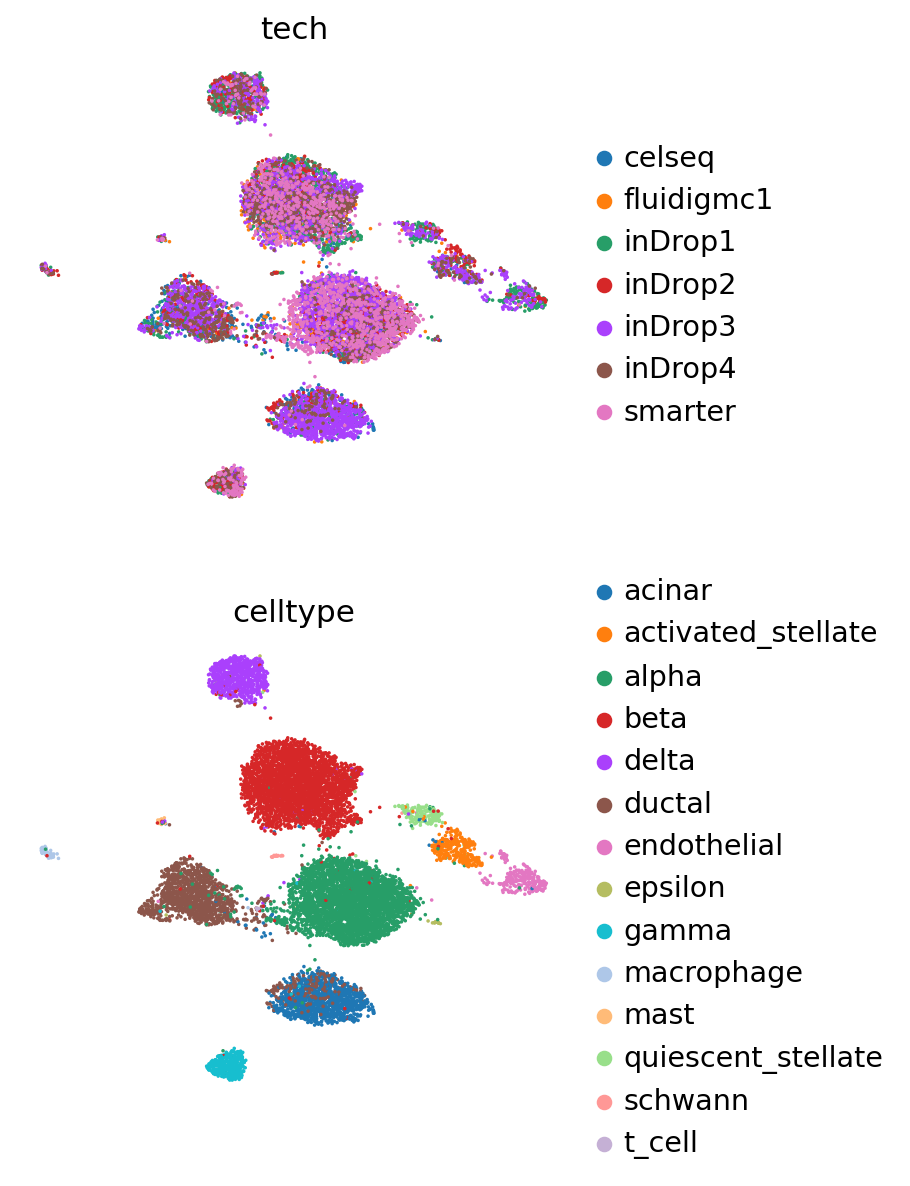

In [10]:
sc.pl.umap(
    adata_ref,
    color=["tech", "celltype"],
    frameon=False,
    ncols=1,
)

#### Update with query

We can load a new model with the query data either using

1. The saved reference model
1. The instance of the reference model

In [11]:
# save the reference model
dir_path = "pancreas_model/"
vae_ref.save(dir_path, overwrite=True)

First we validate that our query data is ready to be loaded into the reference model. Here we run `prepare_query_anndata`, which reorders the genes and pads any missing genes with 0s. This should generally be run before reference mapping with scArches to ensure data correctness. In the case of this tutorial, nothing happens as the query data is already "correct".

In [12]:
# both are valid
scvi.model.SCVI.prepare_query_anndata(adata_query, dir_path)
scvi.model.SCVI.prepare_query_anndata(adata_query, vae_ref)

INFO     File pancreas_model/model.pt already downloaded                                     
INFO     Found 100.0% reference vars in query data.                                          
INFO     Found 100.0% reference vars in query data.                                          


Now we create the new query model instance.

In [13]:
# both are valid
vae_q = scvi.model.SCVI.load_query_data(
    adata_query,
    dir_path,
)
vae_q = scvi.model.SCVI.load_query_data(
    adata_query,
    vae_ref,
)

INFO     File pancreas_model/model.pt already downloaded                                     


/usr/local/lib/python3.7/dist-packages/scvi/data/fields/_layer_field.py:79: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  f"{logger_data_loc} does not contain unnormalized count data. "


This is a typical `SCVI` object, and after training, can be used in any defined way.

For training the query data, we recommend using a `weight_decay` of 0.0. This ensures the latent representation of the reference cells will remain exactly the same if passing them through this new query model.

In [14]:
vae_q.train(max_epochs=200, plan_kwargs=dict(weight_decay=0.0))
adata_query.obsm["X_scVI"] = vae_q.get_latent_representation()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Epoch 1/200:   0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scvi/distributions/_negative_binomial.py:438: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Epoch 200/200: 100%|██████████| 200/200 [01:15<00:00,  2.63it/s, loss=1.76e+03, v_num=1]


In [15]:
sc.pp.neighbors(adata_query, use_rep="X_scVI")
sc.tl.leiden(adata_query)
sc.tl.umap(adata_query)

In [16]:
sc.pl.umap(
    adata_query,
    color=["tech", "celltype"],
    frameon=False,
    ncols=1,
)

#### Visualize reference and query

In [17]:
adata_full = adata_query.concatenate(adata_ref)

The concatenated object has the latent representations of both reference and query, but we are also able to reobtain these values using the query model.

In [18]:
adata_full.obsm["X_scVI"] = vae_q.get_latent_representation(adata_full)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


/usr/local/lib/python3.7/dist-packages/scvi/data/fields/_layer_field.py:79: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  f"{logger_data_loc} does not contain unnormalized count data. "


In [19]:
sc.pp.neighbors(adata_full, use_rep="X_scVI")
sc.tl.leiden(adata_full)
sc.tl.umap(adata_full)

In [20]:
sc.pl.umap(
    adata_full,
    color=["tech", "celltype"],
    frameon=False,
    ncols=1,
)

### Reference mapping with SCANVI

We'll use the same Pancreas dataset, this time we set it up such that we register that the dataset has labels.

The advantage of SCANVI is that we'll be able to predict the cell type labels of the query dataset. In the case of SCVI, a separate classifier (e.g., nearest-neighbor, random forest, etc.) would have to be trained on the reference latent space.

#### Train reference

`SCANVI` tends to perform better in situations where it has been initialized using a pre-trained `SCVI` model. In this case, we will use `vae_ref` that we have already trained above. In other words, a typical `SCANVI` workflow will be:

```python
scvi_model = SCVI(adata_ref, **arches_params)
scvi_model.train()
scanvi_model = SCANVI.from_scvi_model(scvi_model, unlabeled_category="Unknown")
scanvi_model.train()
```

`SCANVI.from_scvi_model` will also run `setup_anndata`. It will use the `batch_key` and `layer` used with `SCVI`, but here we add the `labels_key`.

For this part of the tutorial, we will create a new labels key in the reference anndata object to reflect the common scenario of having no labels for the query data.

In [21]:
adata_ref.obs["labels_scanvi"] = adata_ref.obs["celltype"].values

Applying this workflow in the context of this tutorial:

In [22]:
# unlabeled category does not exist in adata.obs[labels_key]
# so all cells are treated as labeled
vae_ref_scan = scvi.model.SCANVI.from_scvi_model(
    vae_ref,
    unlabeled_category="Unknown",
    labels_key="labels_scanvi",
)

/usr/local/lib/python3.7/dist-packages/scvi/data/fields/_layer_field.py:79: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  f"{logger_data_loc} does not contain unnormalized count data. "


In [23]:
vae_ref_scan.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                             


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/20:   0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scvi/distributions/_negative_binomial.py:438: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Epoch 20/20: 100%|██████████| 20/20 [00:40<00:00,  2.05s/it, loss=851, v_num=1]


In [24]:
adata_ref.obsm["X_scANVI"] = vae_ref_scan.get_latent_representation()
sc.pp.neighbors(adata_ref, use_rep="X_scANVI")
sc.tl.leiden(adata_ref)
sc.tl.umap(adata_ref)

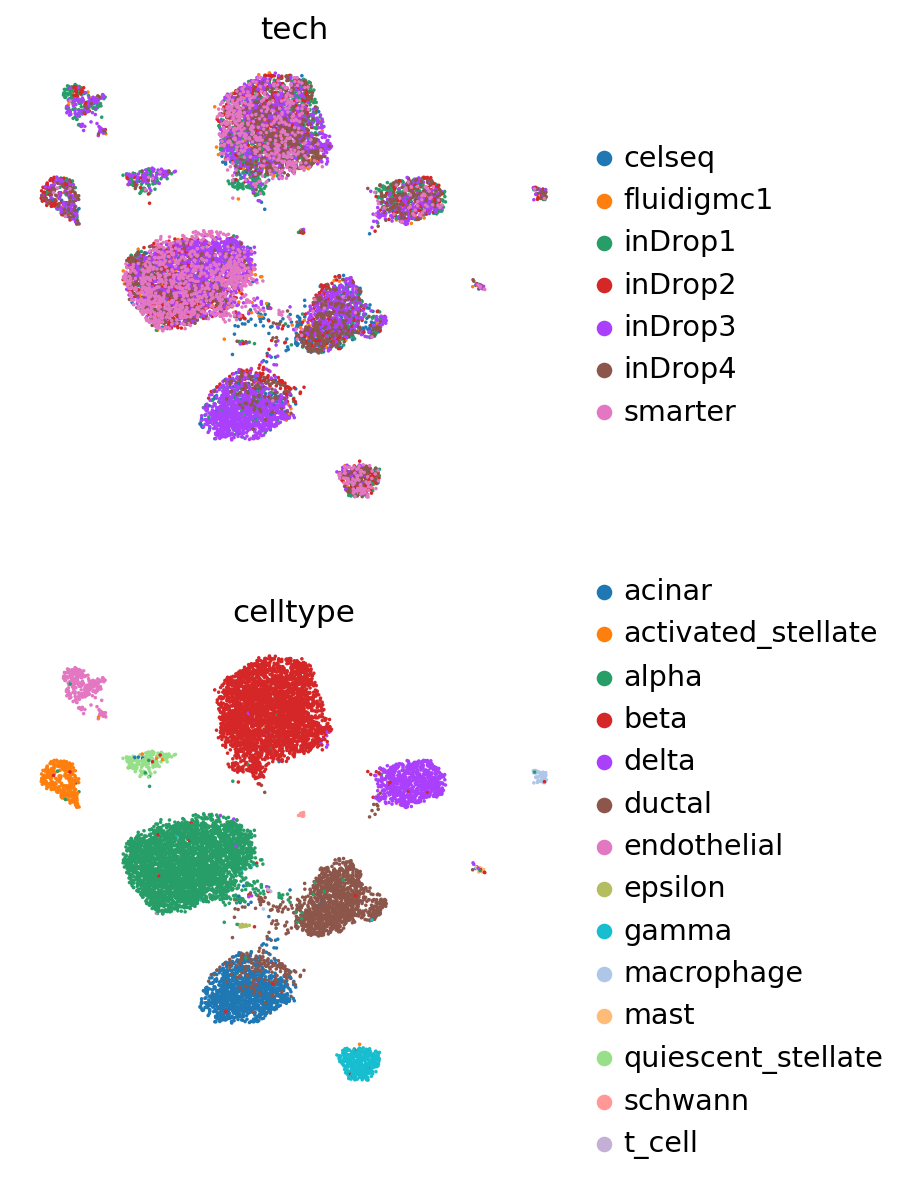

In [25]:
sc.pl.umap(
    adata_ref,
    color=["tech", "celltype"],
    frameon=False,
    ncols=1,
)

#### Update with query

In [26]:
dir_path_scan = "pancreas_model_scanvi/"
vae_ref_scan.save(dir_path_scan, overwrite=True)

In [27]:
# again a no-op in this tutorial, but good practice to use
scvi.model.SCANVI.prepare_query_anndata(adata_query, dir_path_scan)

INFO     File pancreas_model_scanvi/model.pt already downloaded                              
INFO     Found 100.0% reference vars in query data.                                          


Notice that `adata_query.obs["labels_scanvi"]` does not exist. The `load_query_data` method detects this and fills it in `adata_query` with the unlabeled category (here `"Unknown"`).

In [28]:
vae_q = scvi.model.SCANVI.load_query_data(
    adata_query,
    dir_path_scan,
)

INFO     File pancreas_model_scanvi/model.pt already downloaded                              


/usr/local/lib/python3.7/dist-packages/scvi/data/fields/_layer_field.py:79: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  f"{logger_data_loc} does not contain unnormalized count data. "
/usr/local/lib/python3.7/dist-packages/scvi/data/fields/_scanvi.py:90: UserWarning: Missing labels key labels_scanvi. Filling in with unlabeled category Unknown.
  f"Missing labels key {self._original_attr_key}. Filling in with unlabeled category {self._unlabeled_category}."


In [29]:
vae_q.train(
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)

INFO     Training for 100 epochs.                                                            


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scvi/distributions/_negative_binomial.py:438: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Epoch 100/100: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s, loss=1.78e+03, v_num=1]


In [30]:
adata_query.obsm["X_scANVI"] = vae_q.get_latent_representation()
adata_query.obs["predictions"] = vae_q.predict()

In [31]:
df = adata_query.obs.groupby(["celltype", "predictions"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

Text(0, 0.5, 'Observed')

#### Analyze reference and query

In [32]:
adata_full = adata_query.concatenate(adata_ref)

This just makes a column in the anndata corresponding to if the data come from the reference or query sets.

In [33]:
adata_full.obs.batch.cat.rename_categories(["Query", "Reference"], inplace=True)

In [34]:
full_predictions = vae_q.predict(adata_full)
print(f"Acc: {np.mean(full_predictions == adata_full.obs.celltype)}")

adata_full.obs["predictions"] = full_predictions

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


/usr/local/lib/python3.7/dist-packages/scvi/data/fields/_layer_field.py:79: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  f"{logger_data_loc} does not contain unnormalized count data. "


Acc: 0.9651446709803443


In [35]:
sc.pp.neighbors(adata_full, use_rep="X_scANVI")
sc.tl.leiden(adata_full)
sc.tl.umap(adata_full)

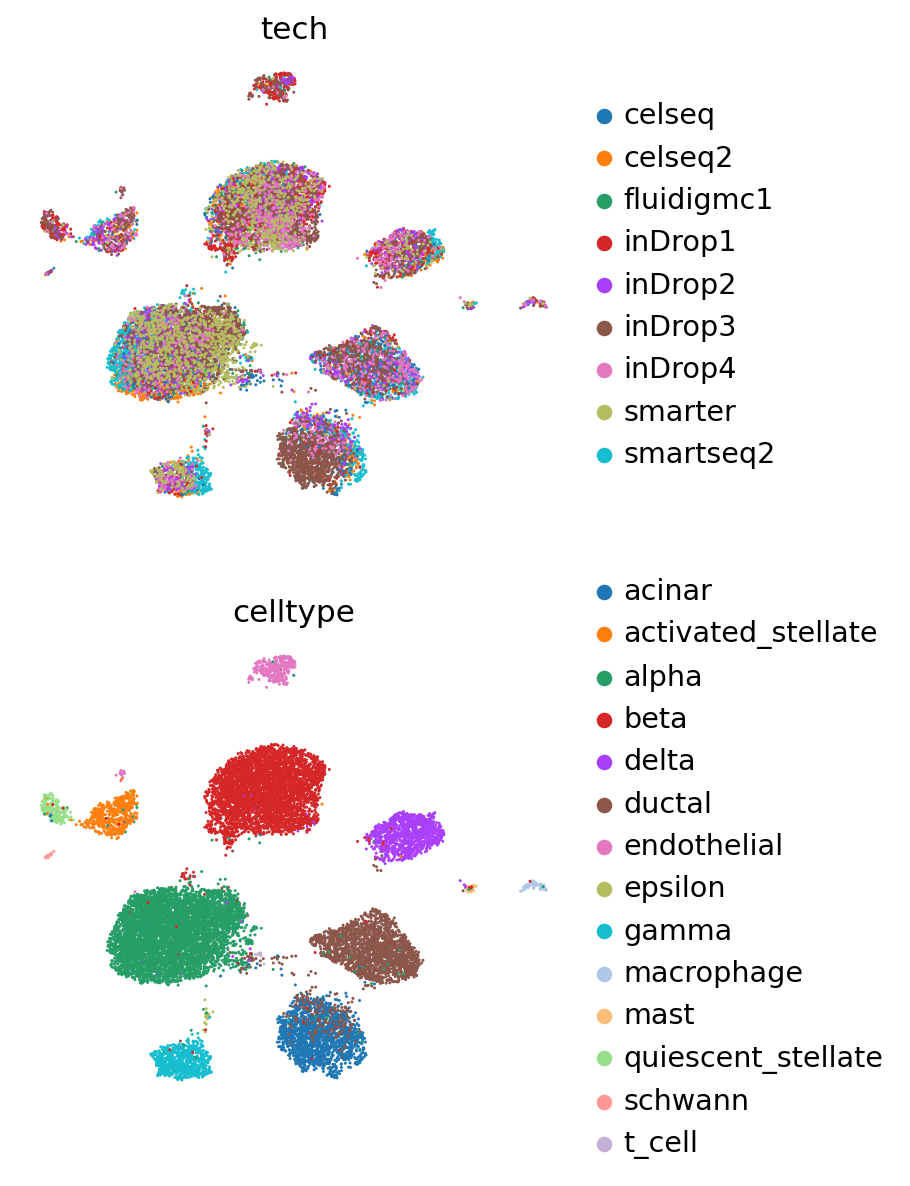

In [36]:
sc.pl.umap(
    adata_full,
    color=["tech", "celltype"],
    frameon=False,
    ncols=1,
)

In [37]:
ax = sc.pl.umap(
    adata_full,
    frameon=False,
    show=False,
)
sc.pl.umap(
    adata_full[: adata_query.n_obs],
    color=["predictions"],
    frameon=False,
    title="Query predictions",
    ax=ax,
    alpha=0.7,
)

ax = sc.pl.umap(
    adata_full,
    frameon=False,
    show=False,
)
sc.pl.umap(
    adata_full[: adata_query.n_obs],
    color=["celltype"],
    frameon=False,
    title="Query observed cell types",
    ax=ax,
    alpha=0.7,
)

/usr/local/lib/python3.7/dist-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


### Reference mapping with TOTALVI

This workflow works very similarly for TOTALVI. Here we demonstrate how to build a CITE-seq reference and use scRNA-seq only data as the query.

#### Assemble data

For totalVI, we will treat two CITE-seq PBMC datasets from 10X Genomics as the reference. These datasets were already filtered for outliers like doublets, as described in the totalVI manuscript. There are 14 proteins in the reference.

In [38]:
adata_ref = scvi.data.pbmcs_10x_cite_seq()

INFO     Downloading file at data/pbmc_10k_protein_v3.h5ad                                   
Downloading...: 24938it [00:00, 119159.97it/s]                             
INFO     Downloading file at data/pbmc_5k_protein_v3.h5ad                                    
Downloading...: 100%|██████████| 18295/18295.0 [00:00<00:00, 109289.36it/s]


/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In general, there will be some necessary data wrangling. For example, we need to provide totalVI with some protein data -- and when it's all zeros, totalVI identifies that the protein data is missing in this "batch".

It could have also been the case that only some of the protein data was missing, in which case we would add zeros for each of the missing proteins.

In [39]:
adata_query = scvi.data.dataset_10x("pbmc_10k_v3")
adata_query.obs["batch"] = "PBMC 10k (RNA only)"
# put matrix of zeros for protein expression (considered missing)
pro_exp = adata_ref.obsm["protein_expression"]
data = np.zeros((adata_query.n_obs, pro_exp.shape[1]))
adata_query.obsm["protein_expression"] = pd.DataFrame(
    columns=pro_exp.columns, index=adata_query.obs_names, data=data
)

INFO     Downloading file at data/10X/pbmc_10k_v3/filtered_feature_bc_matrix.h5              
Downloading...: 37492it [00:02, 18127.05it/s]                             


/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


We do some light QC filtering on the query dataset (doublets, mitochondrial, etc.)

In [40]:
scrub = scr.Scrublet(adata_query.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
adata_query = adata_query[~predicted_doublets].copy()

adata_query.var["mt"] = adata_query.var_names.str.startswith(
    "MT-"
)  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(
    adata_query, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)
adata_query = adata_query[adata_query.obs.pct_counts_mt < 15, :].copy()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.33
Detected doublet rate = 4.7%
Estimated detectable doublet fraction = 55.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.6%
Elapsed time: 16.2 seconds


Now to concatenate the objects, which intersects the genes properly.

In [41]:
adata_full = anndata.concat([adata_ref, adata_query])

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


And split them back up into reference and query (but now genes are properly aligned between objects).

In [42]:
adata_ref = adata_full[
    np.logical_or(adata_full.obs.batch == "PBMC5k", adata_full.obs.batch == "PBMC10k")
].copy()
adata_query = adata_full[adata_full.obs.batch == "PBMC 10k (RNA only)"].copy()

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


We run gene selection on the reference, because that's all that will be avaialble to us at first.

In [43]:
sc.pp.highly_variable_genes(
    adata_ref,
    n_top_genes=4000,
    flavor="seurat_v3",
    batch_key="batch",
    subset=True,
)

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Finally, we use these selected genes for the query dataset as well.

In [44]:
adata_query = adata_query[:, adata_ref.var_names].copy()

#### Train reference

In [45]:
scvi.model.TOTALVI.setup_anndata(
    adata_ref, batch_key="batch", protein_expression_obsm_key="protein_expression"
)

INFO     Using column names from columns of adata.obsm['protein_expression']                 


In [46]:
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
)
vae_ref = scvi.model.TOTALVI(adata_ref, **arches_params)

INFO     Computing empirical prior initialization for protein background.                    


In [47]:
vae_ref.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Epoch 400/400: 100%|██████████| 400/400 [06:13<00:00,  1.07it/s, loss=1.22e+03, v_num=1]


In [48]:
adata_ref.obsm["X_totalVI"] = vae_ref.get_latent_representation()
sc.pp.neighbors(adata_ref, use_rep="X_totalVI")
sc.tl.umap(adata_ref, min_dist=0.4)

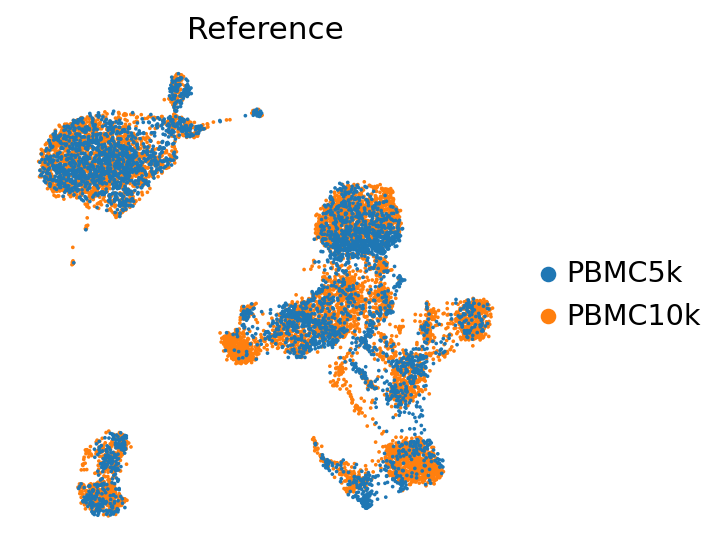

In [49]:
sc.pl.umap(adata_ref, color=["batch"], frameon=False, ncols=1, title="Reference")

In [50]:
dir_path = "saved_model/"
vae_ref.save(dir_path, overwrite=True)

#### Update with query

In [51]:
scvi.model.TOTALVI.prepare_query_anndata(adata_query, dir_path)
vae_q = scvi.model.TOTALVI.load_query_data(
    adata_query,
    dir_path,
)

INFO     File saved_model/model.pt already downloaded                                        
INFO     Found 100.0% reference vars in query data.                                          
INFO     File saved_model/model.pt already downloaded                                        
INFO     Found batches with missing protein expression                                       
INFO     Computing empirical prior initialization for protein background.                    


/usr/local/lib/python3.7/dist-packages/scvi/model/_totalvi.py:133: UserWarning: Some proteins have all 0 counts in some batches. These proteins will be treated as missing measurements; however, this can occur due to experimental design/biology. Reinitialize the model with `override_missing_proteins=True`,to override this behavior.
  warnings.warn(msg, UserWarning)


In [52]:
vae_q.train(200, plan_kwargs=dict(weight_decay=0.0))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Epoch 200/200: 100%|██████████| 200/200 [03:43<00:00,  1.12s/it, loss=759, v_num=1]


In [53]:
adata_query.obsm["X_totalVI"] = vae_q.get_latent_representation()
sc.pp.neighbors(adata_query, use_rep="X_totalVI")
sc.tl.umap(adata_query, min_dist=0.4)

#### Impute protein data for query and visualize

Now that we have updated with the query, we can impute the proteins that were observed in the reference, using the `transform_batch` parameter.

In [54]:
_, imputed_proteins = vae_q.get_normalized_expression(
    adata_query,
    n_samples=10,
    return_mean=True,
    transform_batch=["PBMC10k", "PBMC5k"],
)

Very quickly we can identify the major expected subpopulations of B cells, CD4 T cells, CD8 T cells, monocytes, etc.

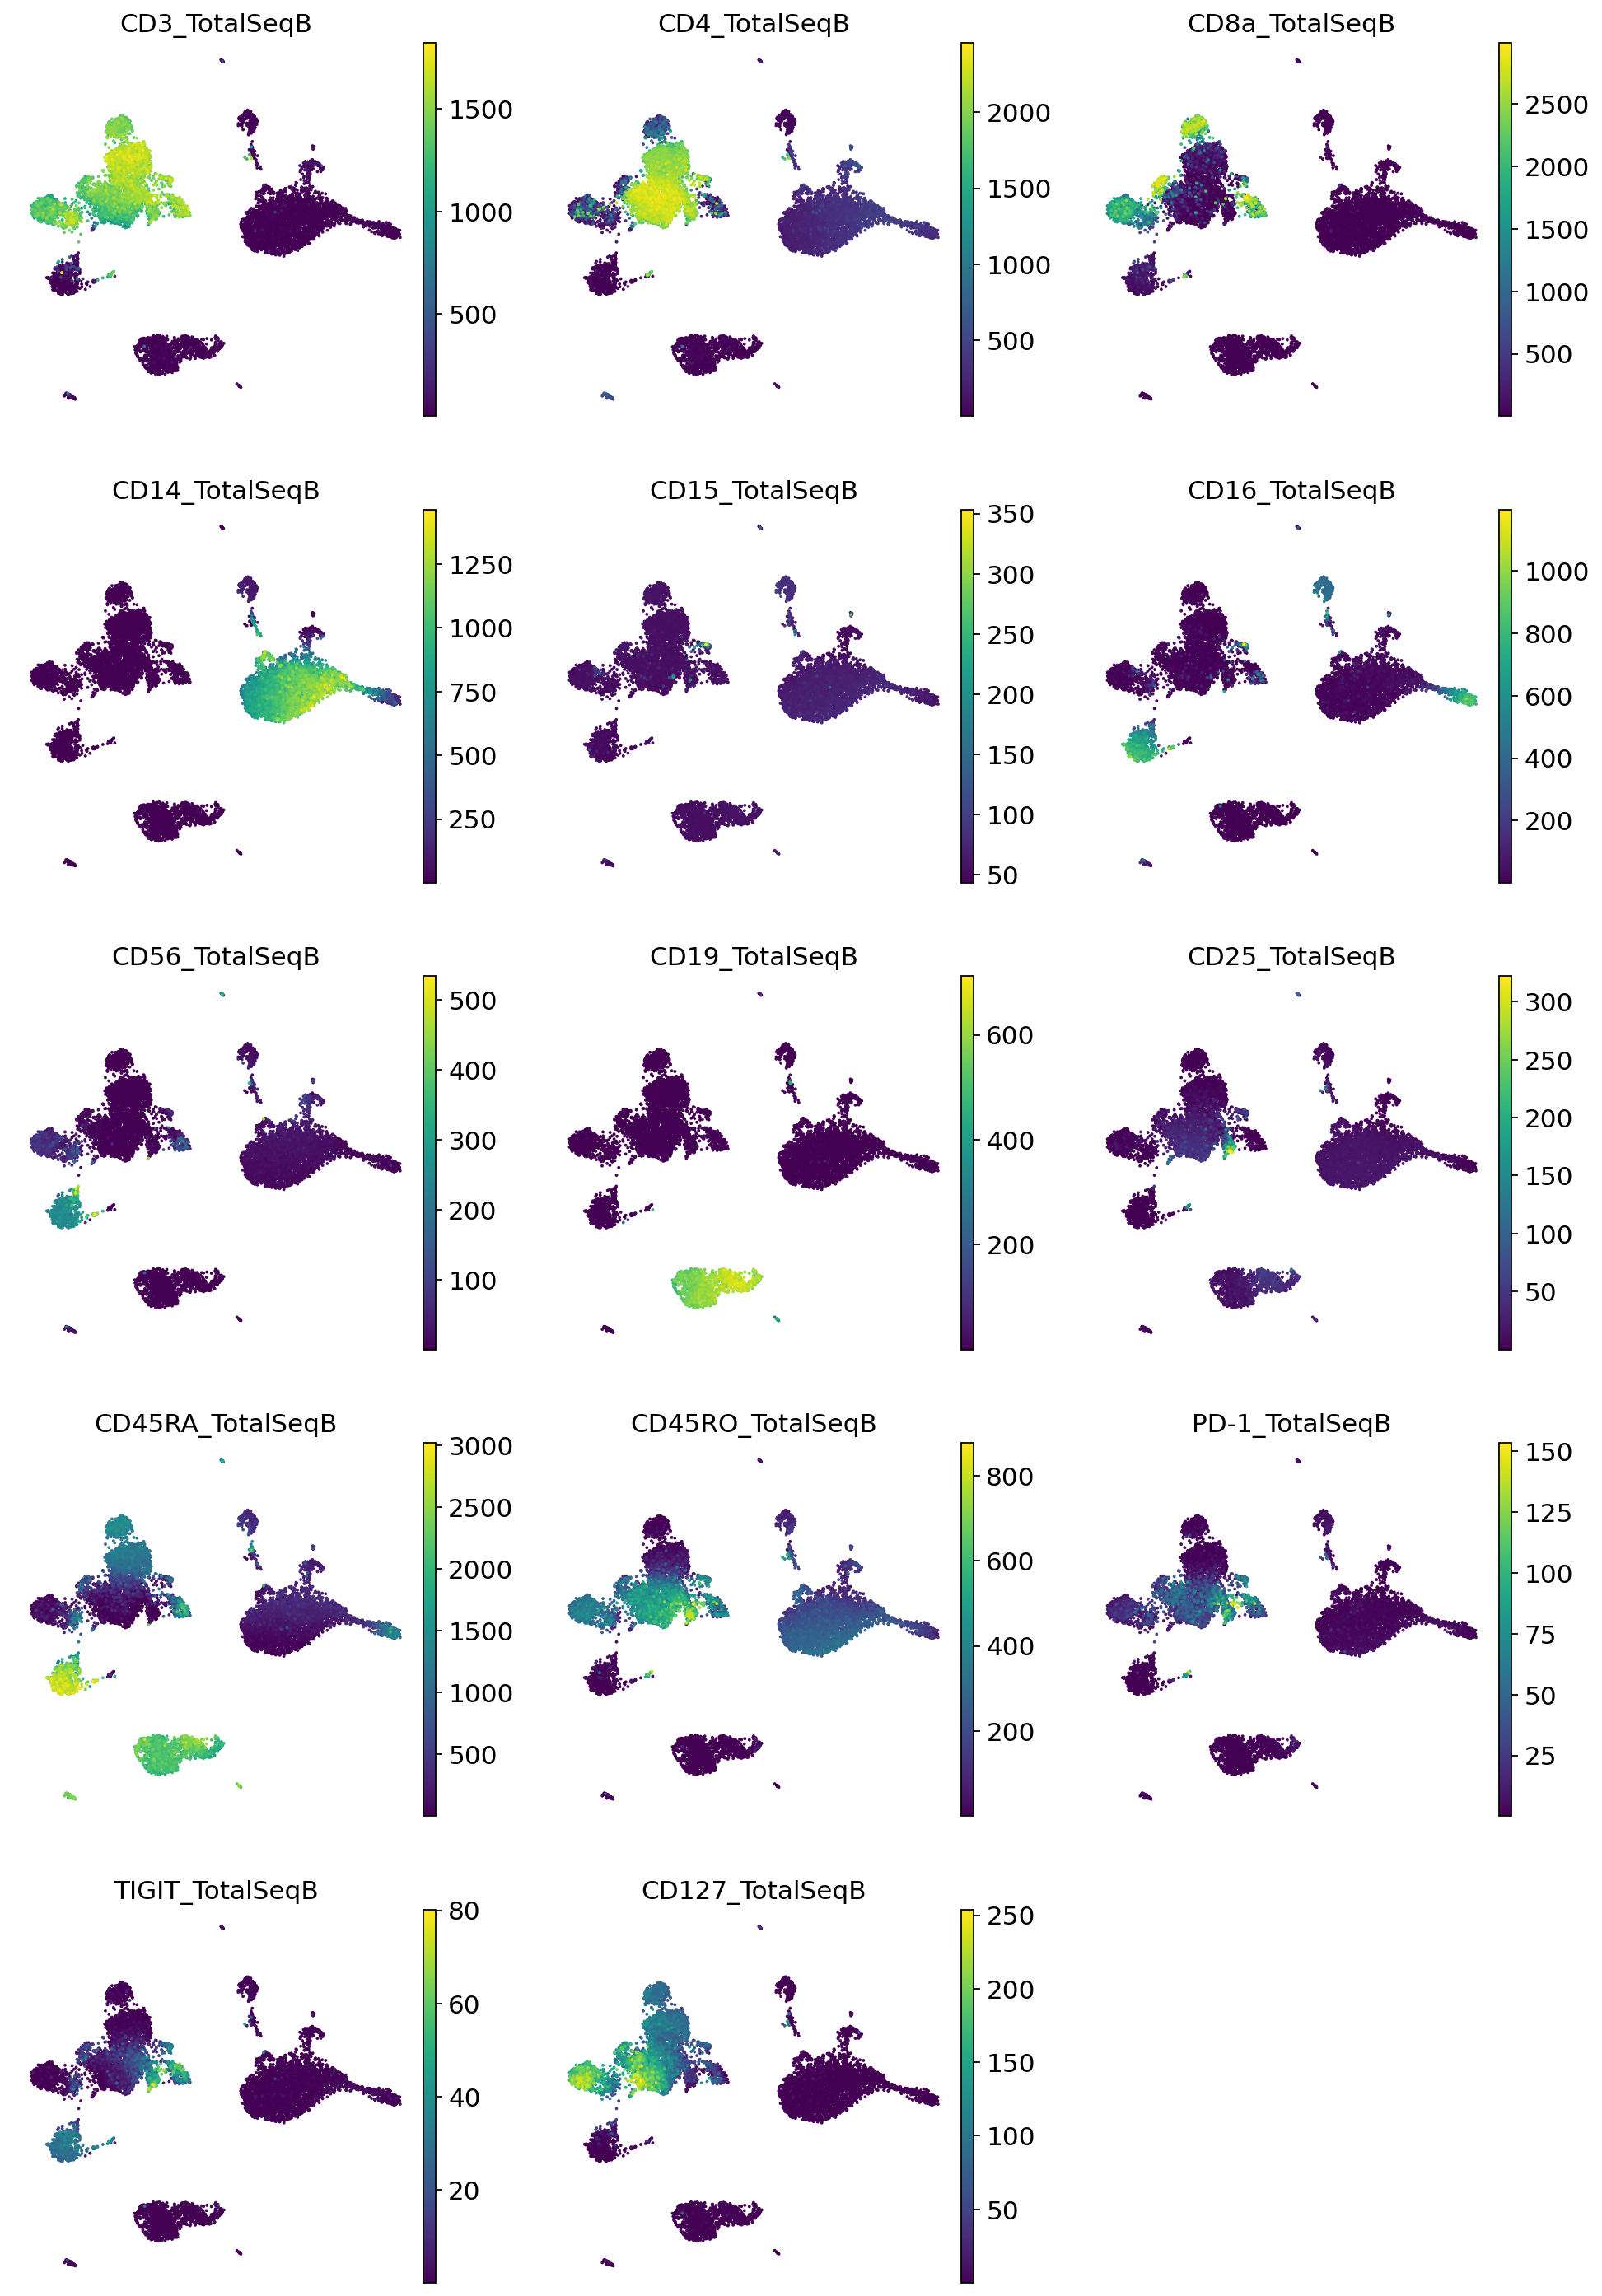

In [55]:
adata_query.obs = pd.concat([adata_query.obs, imputed_proteins], axis=1)

sc.pl.umap(
    adata_query,
    color=imputed_proteins.columns,
    frameon=False,
    ncols=3,
)

#### Visualize reference and query

In [56]:
adata_full_new = adata_query.concatenate(adata_ref, batch_key="none")

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [57]:
adata_full_new.obsm["X_totalVI"] = vae_q.get_latent_representation(adata_full_new)
sc.pp.neighbors(adata_full_new, use_rep="X_totalVI")
sc.tl.umap(adata_full_new, min_dist=0.3)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Found batches with missing protein expression                                       


In [58]:
_, imputed_proteins_all = vae_q.get_normalized_expression(
    adata_full_new,
    n_samples=10,
    return_mean=True,
    transform_batch=["PBMC10k", "PBMC5k"],
)

for i, p in enumerate(imputed_proteins_all.columns):
    adata_full_new.obs[p] = imputed_proteins_all[p].to_numpy().copy()

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


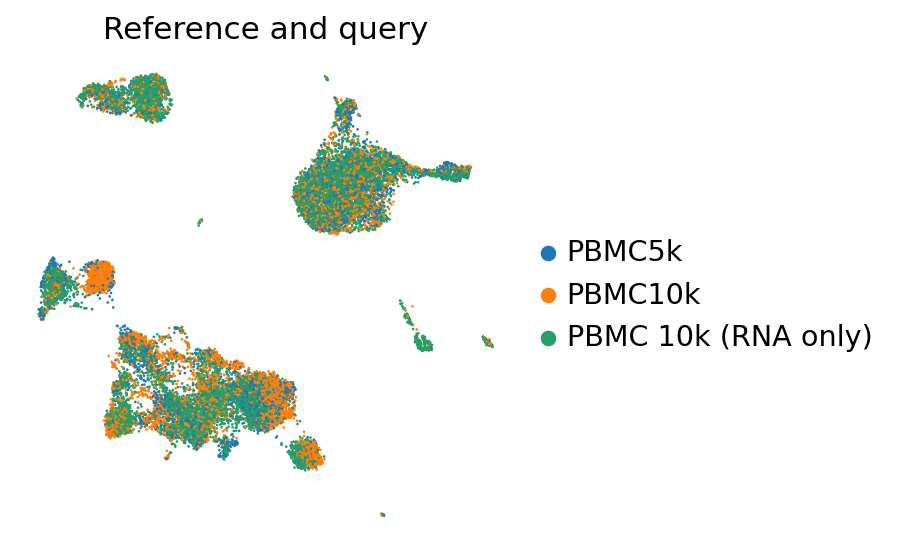

In [59]:
perm_inds = np.random.permutation(np.arange(adata_full_new.n_obs))
sc.pl.umap(
    adata_full_new[perm_inds],
    color=["batch"],
    frameon=False,
    ncols=1,
    title="Reference and query",
)

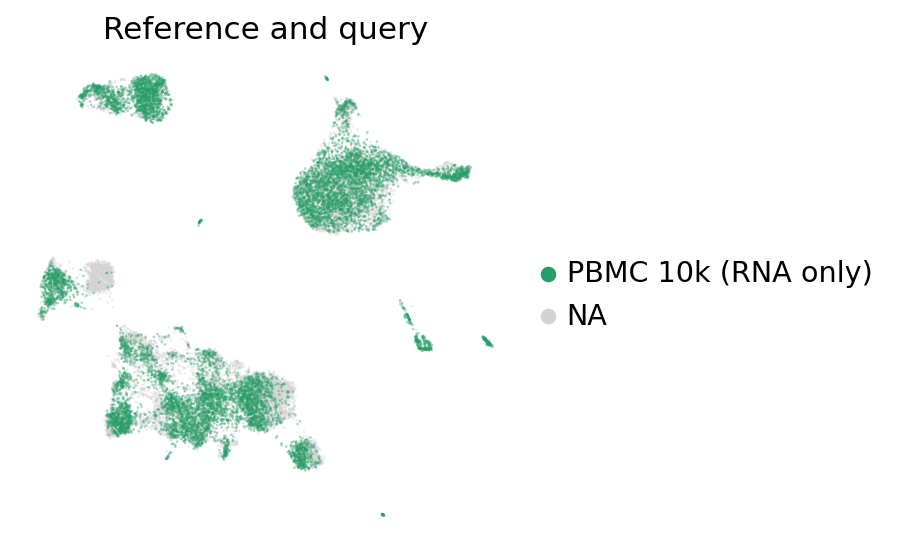

In [60]:
ax = sc.pl.umap(
    adata_full_new,
    color="batch",
    groups=["PBMC 10k (RNA only)"],
    frameon=False,
    ncols=1,
    title="Reference and query",
    alpha=0.4,
)

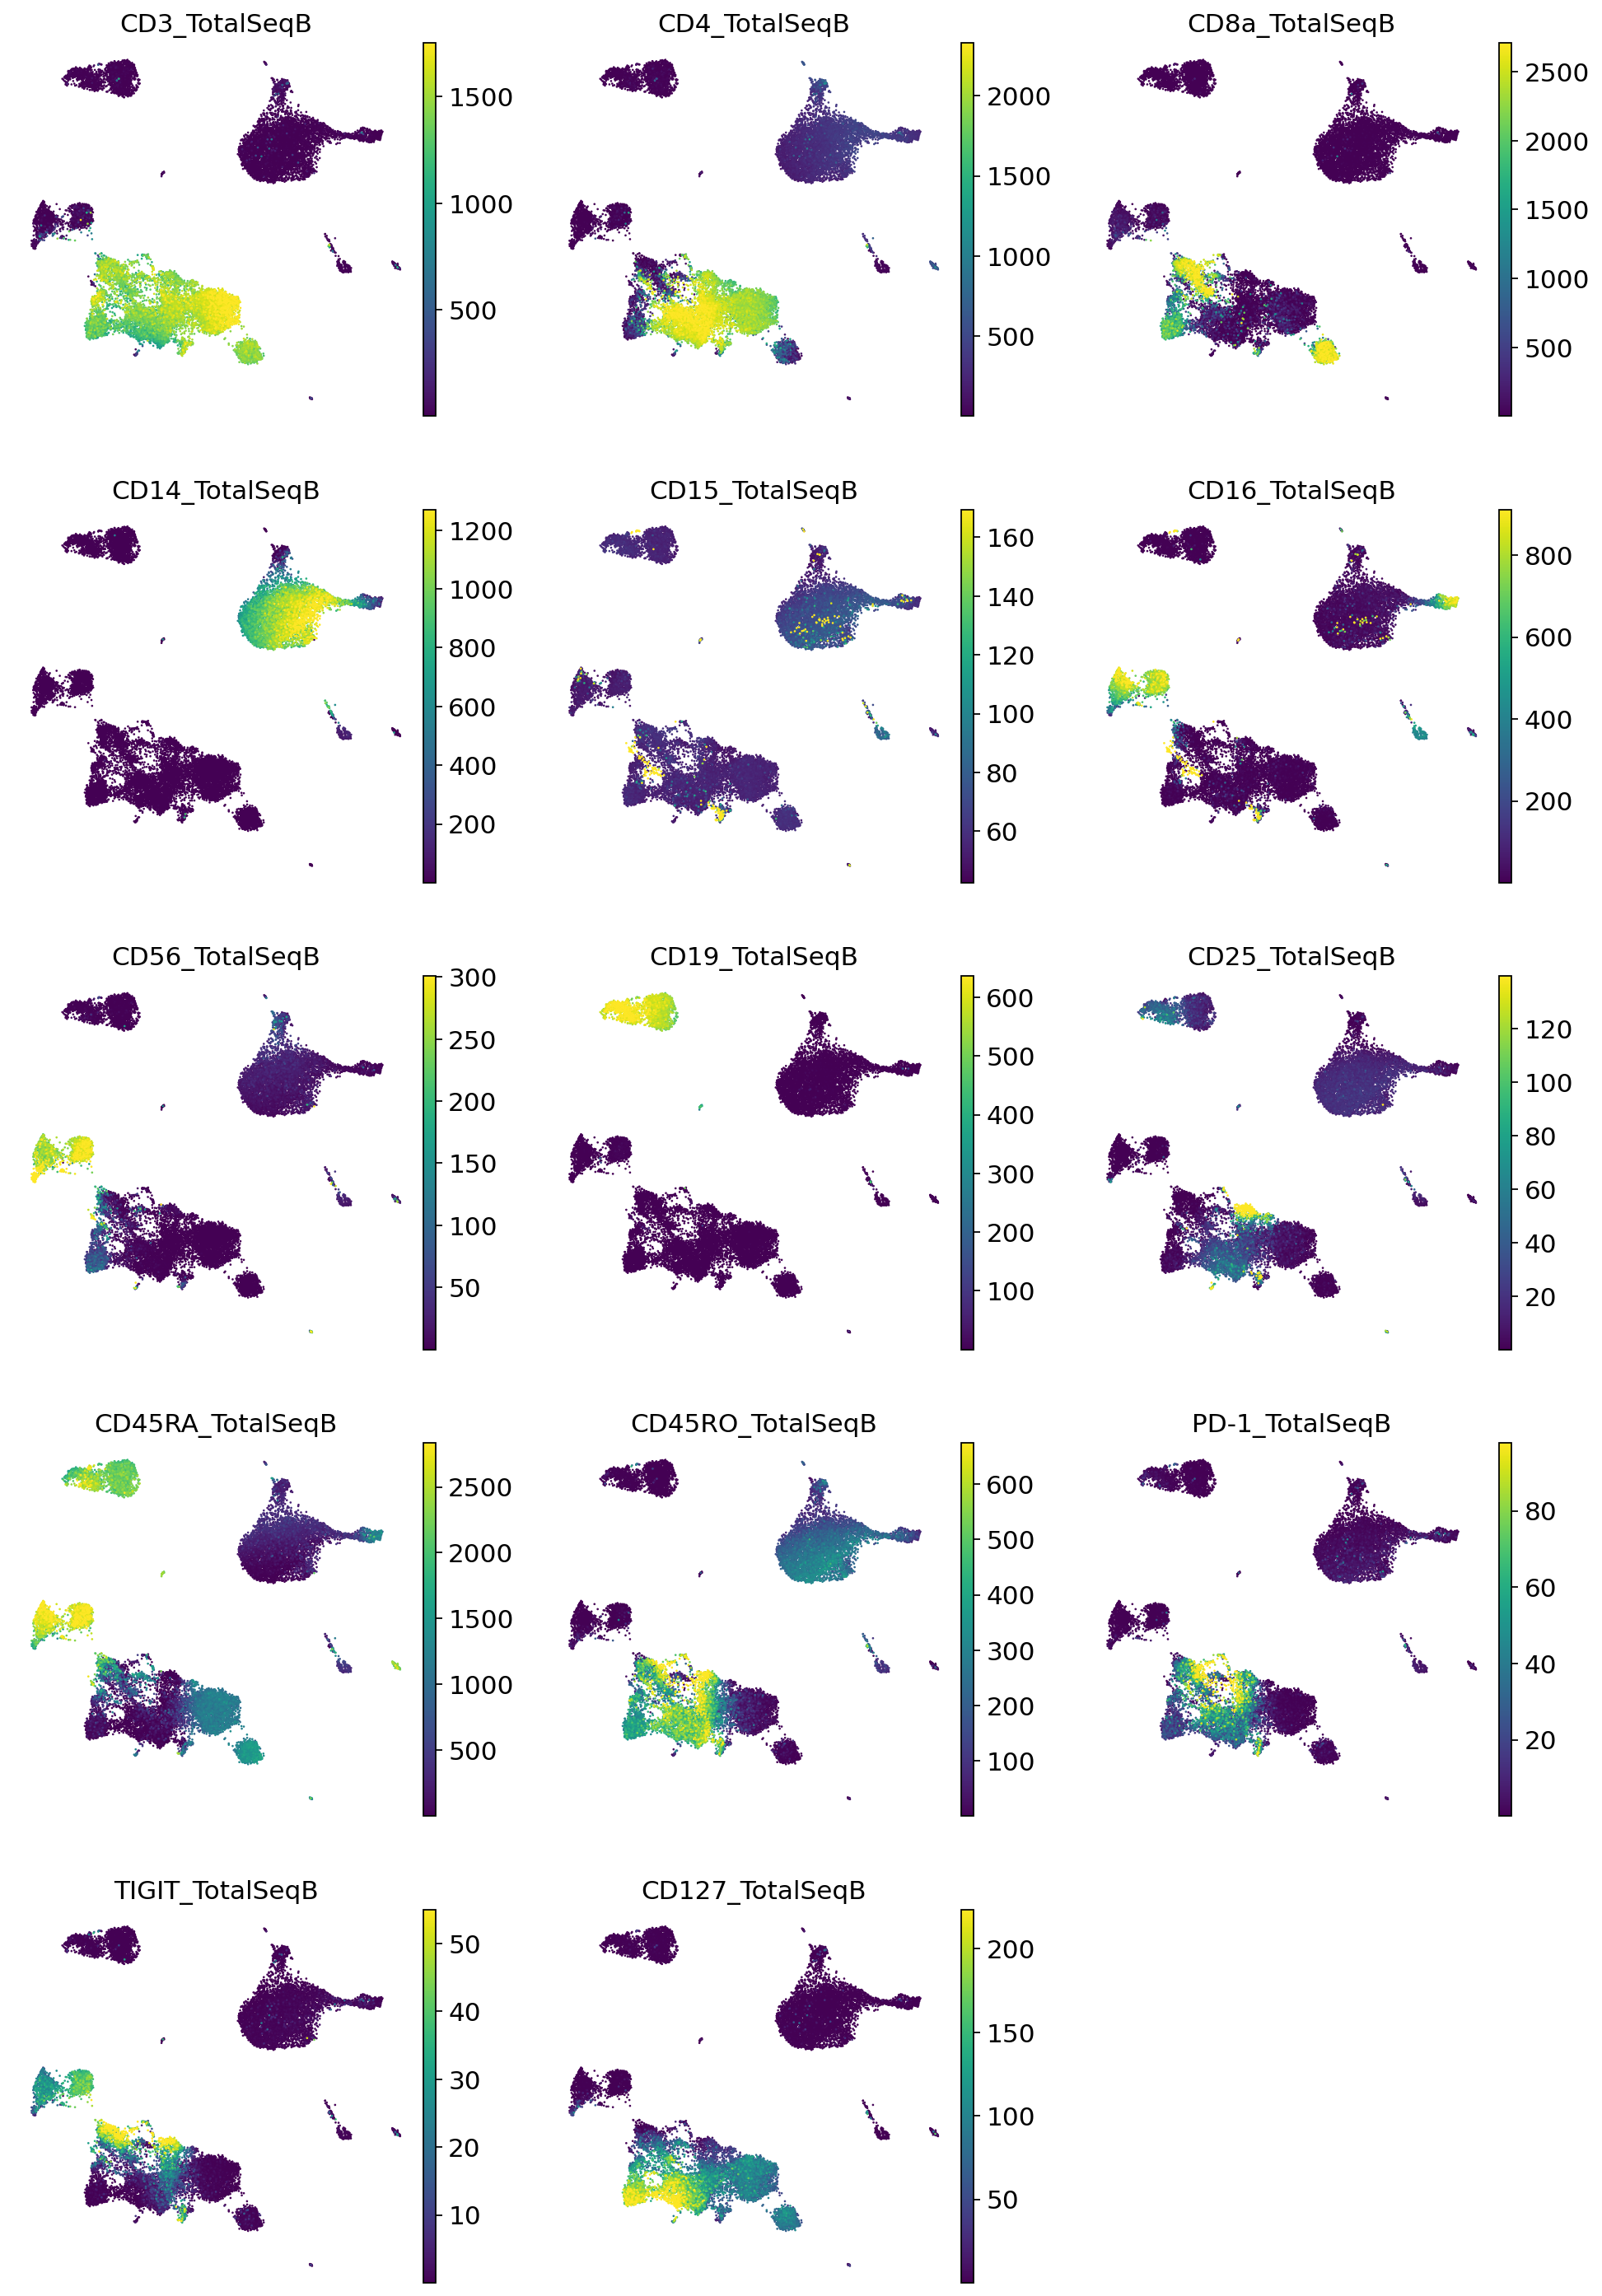

In [61]:
sc.pl.umap(
    adata_full_new,
    color=imputed_proteins_all.columns,
    frameon=False,
    ncols=3,
    vmax="p99",
)